# Network analysis using the origins and divisions

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import json

In [29]:
MAIN_FILE_PATH = "../../1832_v4_preprocessed.csv"

recensement = pd.read_csv(MAIN_FILE_PATH)
recensement.head()

,nom_rue,no_maison,chef_annee_naissance,chef_origine,chef_annee_arrivee,chef_vocation,page,division,chef_vocation_class,chef_origine_class
0,marterey,1,1764.0,tolochenaz,1786.0,charon,1,1-2,NaN,morges
1,marterey,2,NaN,rolle,1821.0,marechal-ferrant,1,1-2,artisanat,rolle
2,marterey,3,1785.0,pailly,NaN,lingere,1,1-2,service,moudon
3,marterey,3,NaN,gingins,NaN,rentier,1,1-2,rente,NaN
4,marterey,3,NaN,gingins,NaN,rentier,1,1-2,rente,NaN


In [30]:
recensement.division.unique()

array(['1-2', '3', '4', '5', '6', '7', '7-8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20'], dtype=object)

In [31]:
# Replace the 7-8 division by 7
recensement["division"] = recensement["division"].replace("7-8", "7")

In [32]:
recensement.division.unique()

array(['1-2', '3', '4', '5', '6', '7', '9', '10', '11', '12', '13', '14',
       '15', '16', '17', '18', '19', '20'], dtype=object)

In [33]:
# Create empty graph
G = nx.Graph()

# Add nodes for streets and job categories
streets = set(recensement['division'].dropna())
job_categories = set(recensement['chef_vocation_class'].dropna())
G.add_nodes_from(streets, bipartite=0)
G.add_nodes_from(job_categories, bipartite=1)

# Iterate over each street and job category
for street in streets:
    street_data = recensement[recensement['division'] == street]
    job_counts = street_data.groupby('chef_vocation_class').size()
    for job_category, count in job_counts.items():
        G.add_edge(street, job_category, weight=count)

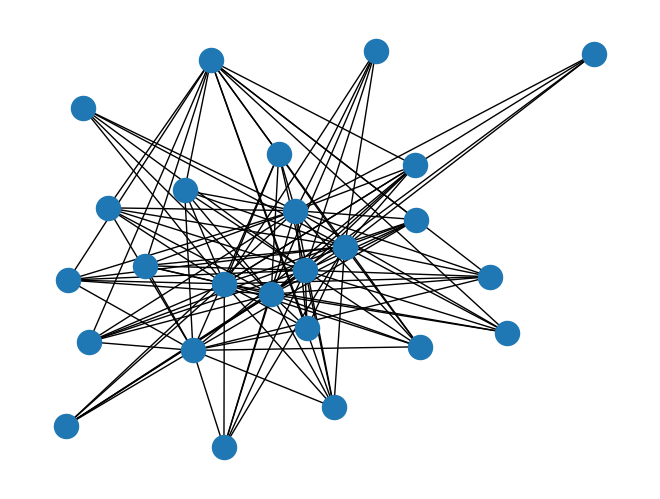

In [34]:
nx.draw(G)

In [35]:

# Get the edges of the graph with their weights
edges = G.edges(data=True)
edge_data = [(u, v, d['weight']) for u, v, d in edges]

# Create a DataFrame from the edge data
df = pd.DataFrame(edge_data, columns=['division', 'job_category', 'Weight'])

# Save the DataFrame to a CSV file
df.to_csv('bipartite_graph.csv', index=False)

In [36]:
nx.write_gexf(G, "bipartite_division_category.gexf")

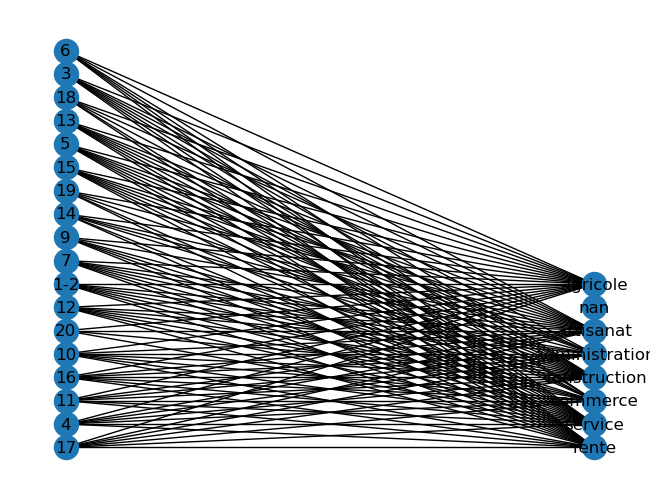

In [37]:
# Create a bipartite graph
B = nx.Graph()

# Add the streets as nodes with the 'bipartite' attribute set to 0
streets = set(recensement['division'])
B.add_nodes_from(streets, bipartite=0)

# Add the job categories as nodes with the 'bipartite' attribute set to 1
job_categories = set(recensement['chef_vocation_class'])
B.add_nodes_from(job_categories, bipartite=1)

# Add the edges between the streets and job categories
edge_data = recensement.groupby(['division', 'chef_vocation_class']).size().reset_index().values.tolist()
B.add_weighted_edges_from(edge_data, weight='weight')

# Get the sets of nodes in each bipartite set
streets = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
job_categories = set(B) - streets

# Define the position of each node
pos = dict()
pos.update((n, (1, i)) for i, n in enumerate(streets))
pos.update((n, (2, i)) for i, n in enumerate(job_categories))

# Draw the graph
nx.draw(B, pos=pos, with_labels=True)
plt.show()

In [38]:
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv("./bipartite_graph.csv")

# Get unique division and job_category names
divisions = df["division"].unique()
job_categories = df["job_category"].unique()

# Create dictionaries to store nodes and links
nodes = []
links = []

# Iterate over divisions
for i, div in enumerate(divisions):
    # Add division node to nodes dictionary
    nodes.append({"id": str(i), "label": str(div), "type": "division", "size": int(df[df["division"] == div]["Weight"].sum())})
    
    # Iterate over job categories and add corresponding links
    for j, cat in enumerate(job_categories):
        weight = int(df[(df["division"] == div) & (df["job_category"] == cat)]["Weight"].sum())
        if weight > 0:
            links.append({"source": str(i), "target": str(cat), "weight": weight})
            
# Iterate over job categories
for i, cat in enumerate(job_categories):
    # Add job category node to nodes dictionary
    nodes.append({"id": str(cat), "label": str(cat), "type": "job_category", "size": int(df[df["job_category"] == cat]["Weight"].sum())})
    
# Create JSON dictionary
json_dict = {"nodes": nodes, "links": links}

# Write JSON dictionary to file
with open("./bipartite_division_type_metiers.json", "w") as f:
    json.dump(json_dict, f, indent=4)